# COLX 585 Project 3.2
## Generated text detection: Project 2

## Introduction

Data: [TweepFake](https://www.kaggle.com/datasets/mtesconi/twitter-deep-fake-text)

...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import require Python libraries

In [ ]:
import tensorflow
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import regex as re

In [ ]:
## Set seed of randomization and working device
manual_seed = 77
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

print(torch.cuda.get_device_name(0))

cuda
Tesla T4


Colab doesn't install `transformers` library automatically. Hence, we should install `transformers` first.

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install spacy

     |████████████████████████████████| 4.0 MB 6.9 MB/s 
     |████████████████████████████████| 6.6 MB 50.8 MB/s 
     |████████████████████████████████| 77 kB 9.0 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 895 kB 56.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 8.3 MB/s 


In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 8.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
from transformers import BertModel, BertTokenizerFast, AdamW, get_linear_schedule_with_warmup
import en_core_web_sm

In [ ]:
spacy_en = en_core_web_sm.load()

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

`Transformers` provides [10+ transformer-based deep learning architectures](https://huggingface.co/transformers/pretrained_models.html) (including English, French). You can implement and load the checkpoints of these architectures using `Transformers` APIs. For each architecture, it provides several class for tokenization, pre-training, and fine-tuning.
Please learn more information [here](https://huggingface.co/transformers/index.html). 

In [ ]:
# # Transformers has a unified API
# # here we list models for 10 transformer architectures
# # for the full list of available pretrained-models: go to https://huggingface.co/transformers/pretrained_models.html
# #          Model          | Tokenizer          | Pretrained weights shortcut
# MODELS = [(BertModel,       BertTokenizerFast,   'bert-base-uncased'),
#           (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
#           (GPT2Model,       GPT2Tokenizer,       'gpt2'),
#           (CTRLModel,       CTRLTokenizer,       'ctrl'),
#           (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
#           (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
#           (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
#           (DistilBertModel, DistilBertTokenizer, 'distilbert-base-cased'),
#           (RobertaModel,    RobertaTokenizer,    'roberta-base'),
#           (XLMRobertaModel, XLMRobertaTokenizer, 'xlm-roberta-base'),
#          ]
         
# # Each architecture is provided with several class for fine-tuning on down-stream tasks, e.g.
# BERT_MODEL_CLASSES = [BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction,
#                       BertForSequenceClassification, BertForTokenClassification, BertForQuestionAnswering]

## Data prepare

Data is already split into train, validation and test:

 Split	| # bot tweets |	# human tweets |	total 
 ----- | ------------ | --------------- | ------ 
 Training set |	10354 |	10358	| 20712 
 Validation set |	1152 |	1150 |	2302 
 Test set |	1280 |	1278 |	2558 

 For bot tweets, GPT-2 (11 accounts, 3861 tweets), RNN (7 accounts, 4181 tweets), and Others (5 accounts, 4876 tweets)

First, we define a function to pre-process input data. 

In [ ]:
# define a function for data preparation
def data_prepare(file_path, lab2ind, tokenizer, max_len = 32, mode = 'train'):
    '''
    file_path: the path to input file. 
                In train mode, the input must be a tsv file that includes two columns where the first is text, and second column is label.
                The first row must be header of columns.

                In predict mode, the input must be a tsv file that includes only one column where the first is text.
                The first row must be header of column.

    lab2ind: dictionary of label classes
    tokenizer: BERT tokenizer
    max_len: maximal length of input sequence
    mode: train or predict
    '''
    # if we are in train mode, we will load two columns (i.e., text and label).
    if mode == 'train':
        # Use pandas to load dataset
        df = pd.read_csv(file_path, header=0, names=['account_name', 'content', 'account_type', 'label'])
        print("Data size ", df.shape)
        labels = df.label.values
        
        # Create sentence and label lists
        labels = [lab2ind[i] for i in labels] 
        print("Label is ", labels[0])
        
        # Convert data into torch tensors
        labels = torch.tensor(labels)

    # if we are in predict mode, we will load one column (i.e., text).
    elif mode == 'predict':
        df = pd.read_csv(file_path, header=0, names=['account_name', 'content', 'account_type', 'label'])
        print("Data size ", df.shape)
        # create placeholder
        labels = []
    else:
        print("the type of mode should be either 'train' or 'predict'. ")
        return
        
    # Create sentence and label lists
    content = df.content.values

    #### REF START ####

    eng_feats = EngFeat(content, spacy_en)
    eng_feats.get_feats()

    # We need to add a special token at the beginning for BERT to work properly.
    content = ["[CLS] " + text for text in content]

    # Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.
    tokenized_texts = [tokenizer.tokenize(text) for text in content]
    
    # if the sequence is longer the maximal length, we truncate it to the pre-defined maximal length
    tokenized_texts = [ text[:max_len+1] for text in tokenized_texts]

    # We also need to add a special token at the end.
    tokenized_texts = [ text+['[SEP]'] for text in tokenized_texts]
    print ("Tokenize the first sentence:\n",tokenized_texts[0])
    
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    print ("Index numbers of the first sentence:\n",input_ids[0])

    # Pad our input seqeunce to the fixed length (i.e., max_len) with index of [PAD] token
    pad_ind = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]
    input_ids = pad_sequences(input_ids, maxlen=max_len+2, dtype="long", truncating="post", padding="post", value=pad_ind)
    print ("Index numbers of the first sentence after padding:\n",input_ids[0])

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for pad tokens
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert all of our data into torch tensors, the required datatype for our model
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    #### REF END ####

    return inputs, labels, masks, eng_feats.feat_list

How the data should look like:
```
Tokenize the first sentence:
 ['[CLS]', 'it', 'was', 'my', 'birthday', ',', 'and', 'my', 'wife', 'and', 'daughter', 'surprised', 'me', 'with', 'some', 'surprise', 'guests', 'and', 'a', 'small', 'party', '.', '[SEP]']
Index numbers of the first sentence:
 [101, 2009, 2001, 2026, 5798, 1010, 1998, 2026, 2564, 1998, 2684, 4527, 2033, 2007, 2070, 4474, 6368, 1998, 1037, 2235, 2283, 1012, 102]
Index numbers of the first sentence after padding:
 [ 101 2009 2001 2026 5798 1010 1998 2026 2564 1998 2684 4527 2033 2007
 2070 4474 6368 1998 1037 2235 2283 1012  102    0    0    0    0    0
    0    0    0    0    0    0]
```

---
### Feat Eng

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/TweepFake/train.csv', 
                      header=0, names=['account_name', 'content', 'account_type', 'label'])
test_input = test_df.content.values

In [ ]:
test_input[:10]

array(['YEA now that note GOOD',
       'Listen to This Charming Man by The Smiths  https://t.co/r12OIXkfUO',
       'wish i can i would be seeing other hoes on the worst part',
       "The decade in the significantly easier schedule I Don't like h…",
       '"Theim class=\\"alignnone size-full wp-image-6017 \\" src=\\"https://t.co/LiAsQsbs99\\" alt=\\"\\" /&gt;\\r\\n&lt;p id=\\"dyD\\"&gt;&lt;img class=\\"alignnone size-full wp-image-6047 \\" src="',
       'matrix 2: pedaphile killer',
       'the world needs more whale stories. I would love to know what whalefacts are hiding in them.',
       'the tweet of time I don’t mean It’s got us free lacroix',
       'nobody:\r\n\r\nNSP: penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis penis pe',
       'Had a wonderful interaction with l

In [ ]:
class EngFeat:
    
    def __init__(self, input_text, language_model):
        self.docs = [language_model(text) for text in input_text]
        self.feat2ids = {'lexical diversity': 0, 'syntactic diversity': 1, 'joint diversity': 2}
        self.feat_list = []

    def get_feats(self):
        for tweet in self.docs:
            self.feat_list.append([])
            # Diversity: NE-tag & POS-tag normalized distribution
            ne_dist = set([ent.text for ent in tweet.ents])
            pos_dist = set([token.pos_ for token in tweet])
            ne_len = len(ne_dist)
            pos_len = len(pos_dist)
            sent_len = len(tweet)
            # lexical diversity
            self.feat_list[-1].append(ne_len/sent_len)
            # syntactic diversity
            self.feat_list[-1].append(pos_len/sent_len)
            # joint diversity
            self.feat_list[-1].append(sum(self.feat_list[-1])/2)

        self.feat_list = torch.tensor(self.feat_list)

In [ ]:
test_engFeat = EngFeat(test_input, spacy_en)
test_engFeat.docs[:5]

[YEA now that note GOOD,
 Listen to This Charming Man by The Smiths  https://t.co/r12OIXkfUO,
 wish i can i would be seeing other hoes on the worst part,
 The decade in the significantly easier schedule I Don't like h…,
 "Theim class=\"alignnone size-full wp-image-6017 \" src=\"https://t.co/LiAsQsbs99\" alt=\"\" /&gt;\r\n&lt;p id=\"dyD\"&gt;&lt;img class=\"alignnone size-full wp-image-6047 \" src="]

In [ ]:
test_engFeat.get_feats()
test_engFeat.feat_list.size()

torch.Size([20712, 3])

In [ ]:
test_engFeat.feat_list[:5]

tensor([[0.2000, 0.8000, 0.5000],
        [0.0000, 0.7000, 0.3500],
        [0.0000, 0.5385, 0.2692],
        [0.0769, 0.7692, 0.4231],
        [0.0667, 0.2000, 0.1333]])

--- 

EDIT OUT?

`Transformers` library also provides several off-the-shelf functions, such as [`batch_encode_plus`](https://huggingface.co/transformers/master/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase.batch_encode_plus) and [`encode_plus`](https://huggingface.co/transformers/master/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase.encode_plus), to help you create BERT input tensors. The codes between `REF START` and `REF END` can be replaced with `batch_encode_plus()`. 

We use `BertTokenizerFast.from_pretrained()` to load vocabulary of pretrained model. The first argument should be either a string with the `shortcut name` of a pretrained model or a path to a directory containing model vocabulary file, `vocab.txt`. `Transformers` provides many pre-trained checkpoints with pre-defined `shortcut name`. If the argument is a correct model identifier listed on [here](https://huggingface.co/models), the model will download the vocabulary and load it to tokenizer automatically. If it doesn't match any model identifier, the model will use this argument as a path to load the vocabulary. 

---

We use ["bert-base-uncased"](https://github.com/google-research/bert) which refers to the **12-layer, 768-hidden, 12-heads, 110M parameters** [variant of BERT model](https://huggingface.co/bert-base-uncased). The vocabulary of "bert-base-uncased" was generated using bype-pair encoding and includes 30,522 WordPieces. 

In [ ]:
model_path = "bert-base-uncased"
# define label to number dictionary
lab2ind = {'human': 0, 'gpt2': 1, 'rnn': 2, 'others': 3}

# tokenizer from pre-trained BERT model
tokenizer = BertTokenizerFast.from_pretrained(model_path,do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Inspect the train data

In [ ]:
data_folder_path = "/content/drive/MyDrive/Colab Notebooks/data/TweepFake/"
train_df = pd.read_csv(data_folder_path+"train.csv")
print('Info about the train dataset:')
train_df.info()
print('\nLabel counts for the train dataset:')
train_df['class_type'].value_counts()

Info about the train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20712 entries, 0 to 20711
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   screen_name   20712 non-null  object
 1   text          20712 non-null  object
 2   account.type  20712 non-null  object
 3   class_type    20712 non-null  object
dtypes: object(4)
memory usage: 647.4+ KB

Label counts for the train dataset:


human     10358
others     3920
rnn        3325
gpt2       3109
Name: class_type, dtype: int64

### Extract train and validation data

In [ ]:
# Use defined funtion to extract data
print('Train sample:')
train_inputs, train_labels, train_masks, train_featlist = data_prepare(data_folder_path+"train.csv", lab2ind,tokenizer)
print('\nValidation sample:')
validation_inputs, validation_labels, validation_masks, validation_featlist = data_prepare(data_folder_path+"validation.csv", lab2ind,tokenizer)
print('\nTest sample:')
test_inputs, test_labels, test_masks, test_featlist = data_prepare(data_folder_path+"test.csv", lab2ind,tokenizer)

Train sample:
Data size  (20712, 4)
Label is  3


Token indices sequence length is longer than the specified maximum sequence length for this model (2194 > 512). Running this sequence through the model will result in indexing errors


Tokenize the first sentence:
 ['[CLS]', 'ye', '##a', 'now', 'that', 'note', 'good', '[SEP]']
Index numbers of the first sentence:
 [101, 6300, 2050, 2085, 2008, 3602, 2204, 102]
Index numbers of the first sentence after padding:
 [ 101 6300 2050 2085 2008 3602 2204  102    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]

Validation sample:
Data size  (2302, 4)
Label is  0
Tokenize the first sentence:
 ['[CLS]', 'tight', ',', 'tight', ',', 'tight', ',', 'yeah', '!', '!', '!', 'https', ':', '/', '/', 't', '.', 'co', '/', 'w', '##j', '##3', '##n', '##v', '##ppa', '##sw', '[SEP]']
Index numbers of the first sentence:
 [101, 4389, 1010, 4389, 1010, 4389, 1010, 3398, 999, 999, 999, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1059, 3501, 2509, 2078, 2615, 13944, 26760, 102]
Index numbers of the first sentence after padding:
 [  101  4389  1010  4389  1010  4389  1010  3398   999   999   999 16770
  1024  10

In [ ]:
train_inputs.shape

torch.Size([20712, 34])

### Create DataLoader

Create an iterator of our data with `torch DataLoader`. This helps us to save on memory during training.

For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32. We use 32 batch size here. 



In [ ]:
batch_size = 8

In [ ]:
# We'll take training samples in random order in each epoch. 
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_featlist)
train_dataloader = DataLoader(train_data, 
                              sampler = RandomSampler(train_data), # Select batches randomly
                              batch_size=batch_size)

# We'll just read validation set sequentially.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_featlist)
validation_dataloader = DataLoader(validation_data, 
                                   sampler = SequentialSampler(validation_data), # Pull out batches sequentially.
                                   batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels, test_featlist)
test_dataloader = DataLoader(test_data, 
                             sampler = SequentialSampler(test_data), # Pull out batches sequentially.
                             batch_size=batch_size)


## Loading pre-trained model example

In [ ]:
bert_model = BertModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True).to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's use the first batch as an example to explore BERT model.

In [ ]:
dataiter = iter(train_dataloader)
batch = dataiter.next()
# Add batch to GPU
batch = tuple(t.to(device) for t in batch)
# Unpack the inputs from our dataloader
input_ids, input_mask, labels, featlist = batch

We set `output_hidden_states=True, output_attentions=True` so the output of `bert_model` will be 4 variables (i.e., `last_hidden_state, pooler_output, hidden_states, attentions`).

In [ ]:
outputs = bert_model(input_ids, attention_mask = input_mask)

In [ ]:
print(outputs.keys())  # outputs is a dictionary

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])


In [ ]:
last_hidden_state = outputs["last_hidden_state"]
pooler_output = outputs["pooler_output"]
hidden_states = outputs["hidden_states"]
attentions = outputs["attentions"]

1. `last_hidden_state`: sequence of hidden-states at the output of the last layer.

In [ ]:
last_hidden_state.shape # [batch size, seq length, hidden size]

torch.Size([8, 34, 768])

2. `pooler_output`: last layer hidden-state of the first token of the sequence (classification token, `[CLS]`).

In [ ]:
pooler_output.shape # [batch size, hidden size]

torch.Size([8, 768])

3. `hidden_states`: list of `Tensor` (one for the output of each layer + the output of the embeddings) of shape `[batch_size, sequence_length, hidden_size]`: Hidden-states of the model at the output of each layer plus the outputs of the embedding layer. 

In [ ]:
print(len(hidden_states))

13


Let's take a look at each item in this list.

In [ ]:
for i, item in enumerate(hidden_states):
  print("layer " + str(i), item.shape) # [batch size, sequence length, hidden size]

layer 0 torch.Size([8, 34, 768])
layer 1 torch.Size([8, 34, 768])
layer 2 torch.Size([8, 34, 768])
layer 3 torch.Size([8, 34, 768])
layer 4 torch.Size([8, 34, 768])
layer 5 torch.Size([8, 34, 768])
layer 6 torch.Size([8, 34, 768])
layer 7 torch.Size([8, 34, 768])
layer 8 torch.Size([8, 34, 768])
layer 9 torch.Size([8, 34, 768])
layer 10 torch.Size([8, 34, 768])
layer 11 torch.Size([8, 34, 768])
layer 12 torch.Size([8, 34, 768])


4. `attentions`: list of `Tensor` (one for each layer) of shape `[batch_size, num_heads, sequence_length, sequence_length]`: Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

In [ ]:
print(len(attentions))

12


In [ ]:
for i, item in enumerate(attentions):
  print("layer " + str(i), item.shape) # [batch size, num_heads, sequence length, sequence_length]

layer 0 torch.Size([8, 12, 34, 34])
layer 1 torch.Size([8, 12, 34, 34])
layer 2 torch.Size([8, 12, 34, 34])
layer 3 torch.Size([8, 12, 34, 34])
layer 4 torch.Size([8, 12, 34, 34])
layer 5 torch.Size([8, 12, 34, 34])
layer 6 torch.Size([8, 12, 34, 34])
layer 7 torch.Size([8, 12, 34, 34])
layer 8 torch.Size([8, 12, 34, 34])
layer 9 torch.Size([8, 12, 34, 34])
layer 10 torch.Size([8, 12, 34, 34])
layer 11 torch.Size([8, 12, 34, 34])


5. concat bert output with engineered feature

In [ ]:
torch.cat((pooler_output, featlist), dim=1).size()

torch.Size([8, 771])

## Creating `Bert_cls` class

Now, we put everthing together. We bulid a `Bert_cls` class to train a BERT classifier end-to-end.

In [ ]:
class Bert_cls(nn.Module):

    def __init__(self, lab2ind, model_path, hidden_size, dropout):
        super(Bert_cls, self).__init__()
        self.model_path = model_path
        self.hidden_size = hidden_size
        # self.bert_hidden_size = bert_hidden_size
        # self.rnn_hidden_size = rnn_hidden_size
        # self.rnn_layer_num = rnn_layer_num
        # self.bidirectional = bidirectional

        self.bert_model = BertModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True)
        
        self.label_num = len(lab2ind)
        
        self.dense = nn.Linear(self.hidden_size+3, self.hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.hidden_size, self.label_num)

    def forward(self, bert_ids, bert_mask, feat_list):
        outputs = self.bert_model(input_ids=bert_ids, attention_mask = bert_mask)
        pooler_output = outputs['pooler_output']
        bert_attentions = outputs['attentions']

        x = torch.cat((pooler_output, feat_list), dim=1)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        fc_output = self.fc(x)

        return fc_output, bert_attentions 


### Hyperparameters

In [ ]:
HIDDEN_SIZE = 768
# HIDDEN_SIZE = 1024

# BERT_HIDDEN_SIZE = 768
# LSTM_HIDDEN_SIZE = 512
# RNN_LAYER_NUM = 1
# BIDIRECTIONAL = True
DROPOUT = 0.1

# rnn_layer_num, bidirectional, dropout

Instantiate model.

In [ ]:
bert_model = Bert_cls(lab2ind, 
                      model_path, 
                      HIDDEN_SIZE,
                      # BERT_HIDDEN_SIZE, 
                      # LSTM_HIDDEN_SIZE, 
                      # RNN_LAYER_NUM,
                      # BIDIRECTIONAL,
                      DROPOUT).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


---
Not used

`Transformers` library also provides a class, [`BertForSequenceClassification`](https://huggingface.co/transformers/master/model_doc/bert.html#bertforsequenceclassification), to automatically create classifier. Namly, this `bert_model` can be instantiated by 

```bert_model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=len(lab2ind)).to(device)```

---

Count the number of parameters. 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(bert_model):,} trainable parameters')

The model has 110,078,212 trainable parameters


## Optimizer and Learning Rate Scheduler

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges (from Appendix A.3 of the [paper](https://arxiv.org/pdf/1810.04805.pdf)):

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

Hypterparameters for BERT large model:

* Batch size: 32
* Learning rate (Adam): 2e-5
* Number of epochs: 3

Hypterparameters for BERT base model:

* Batch size: 8
* Learning rate (Adam): 3e-5
* Number of epochs: 3

In [ ]:
# Parameters:
lr = 3e-5
max_grad_norm = 1.0
epochs = 3
warmup_proportion = 0.1
num_training_steps  = len(train_dataloader) * epochs
num_warmup_steps = num_training_steps * warmup_proportion

### In Transformers, optimizer and schedules are instantiated like this:
# Note: AdamW is a class from the huggingface library
# the 'W' stands for 'Weight Decay"
optimizer = AdamW(bert_model.parameters(), lr=lr, correct_bias=False)
# schedules
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

# We use nn.CrossEntropyLoss() as our loss function. 
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Model training

We define a `train()` function. 

In [ ]:
def train(model, iterator, optimizer, scheduler, criterion):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        input_ids, input_mask, labels, featlist = batch

        outputs,_ = model(input_ids, input_mask, featlist)

        loss = criterion(outputs, labels)
        # delete used variables to free GPU memory
        del batch, input_ids, input_mask, labels, featlist
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping is not in AdamW anymore
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.cpu().item()
        optimizer.zero_grad()
    
    # free GPU memory
    if device == 'cuda':
        torch.cuda.empty_cache()

    return epoch_loss / len(iterator)

We define a `evaluate()` function. 

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    all_pred=[]
    all_label = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            input_ids, input_mask, labels, featlist = batch

            outputs,_ = model(input_ids, input_mask, featlist)
            
            loss = criterion(outputs, labels)

            # delete used variables to free GPU memory
            del batch, input_ids, input_mask, featlist
            epoch_loss += loss.cpu().item()

            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(labels.cpu())
    
    accuracy = accuracy_score(all_label, all_pred)
    f1score = f1_score(all_label, all_pred, average='macro') 
    return epoch_loss / len(iterator), accuracy, f1score

### Training model

In [ ]:
# create checkpoint directory
import os
save_path = '/content/drive/MyDrive/Colab Notebooks/ckpt/TweepFake/'
if os.path.exists(save_path) == False:
    os.makedirs(save_path)

In [ ]:
# Train the model
loss_list = []
acc_list = []

for epoch in trange(epochs, desc="Epoch"):
    train_loss = train(bert_model, train_dataloader, optimizer, scheduler, criterion)  
    val_loss, val_acc, val_f1 = evaluate(bert_model, validation_dataloader, criterion)
    test_loss, test_acc, test_f1 = evaluate(bert_model, test_dataloader, criterion)

    # Create checkpoint at end of each epoch
    state = {
        'epoch': epoch,
        'state_dict': bert_model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }

    torch.save(state, save_path+"/BERT_base_"+str(epoch+1)+".pt")

    print('\n Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, val_acc, val_f1))
    print('Test Accuracy: {:.4f}, Test F1: {:.4f}'.format(test_acc, test_f1))
    

Epoch:  33%|███▎      | 1/3 [04:20<08:41, 260.89s/it]


 Epoch [1/3], Train Loss: 0.4946, Validation Loss: 0.4217, Validation Accuracy: 0.8467, Validation F1: 0.8506
Test Accuracy: 0.8421, Test F1: 0.8408


Epoch:  67%|██████▋   | 2/3 [08:44<04:22, 262.70s/it]


 Epoch [2/3], Train Loss: 0.2607, Validation Loss: 0.4264, Validation Accuracy: 0.8745, Validation F1: 0.8712
Test Accuracy: 0.8640, Test F1: 0.8537


Epoch: 100%|██████████| 3/3 [13:05<00:00, 261.70s/it]


 Epoch [3/3], Train Loss: 0.1110, Validation Loss: 0.6000, Validation Accuracy: 0.8766, Validation F1: 0.8743
Test Accuracy: 0.8679, Test F1: 0.8603


In [ ]:
# Train the model
epochs = 5
loss_list = []
acc_list = []

for epoch in trange(epochs, desc="Epoch"):
    train_loss = train(bert_model, train_dataloader, optimizer, scheduler, criterion)  
    val_loss, val_acc, val_f1 = evaluate(bert_model, validation_dataloader, criterion)
    test_loss, test_acc, test_f1 = evaluate(bert_model, test_dataloader, criterion)

    # Create checkpoint at end of each epoch
    state = {
        'epoch': epoch,
        'state_dict': bert_model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }

    torch.save(state, save_path+"/BERT_base_"+str(epoch+4)+".pt")

    print('\n Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, val_acc, val_f1))
    print('Test Accuracy: {:.4f}, Test F1: {:.4f}'.format(test_acc, test_f1))
    

Epoch:  20%|██        | 1/5 [04:06<16:26, 246.70s/it]


 Epoch [1/5], Train Loss: 0.4929, Validation Loss: 0.3594, Validation Accuracy: 0.8588, Validation F1: 0.8427
Test Accuracy: 0.8651, Test F1: 0.8436


Epoch:  40%|████      | 2/5 [08:17<12:27, 249.18s/it]


 Epoch [2/5], Train Loss: 0.2572, Validation Loss: 0.5116, Validation Accuracy: 0.8579, Validation F1: 0.8477
Test Accuracy: 0.8753, Test F1: 0.8619


Epoch:  60%|██████    | 3/5 [12:28<08:19, 249.76s/it]


 Epoch [3/5], Train Loss: 0.1110, Validation Loss: 0.6373, Validation Accuracy: 0.8732, Validation F1: 0.8698
Test Accuracy: 0.8780, Test F1: 0.8715


Epoch:  80%|████████  | 4/5 [16:37<04:09, 249.78s/it]


 Epoch [4/5], Train Loss: 0.0569, Validation Loss: 0.6373, Validation Accuracy: 0.8732, Validation F1: 0.8698
Test Accuracy: 0.8780, Test F1: 0.8715


Epoch: 100%|██████████| 5/5 [20:48<00:00, 249.69s/it]


 Epoch [5/5], Train Loss: 0.0533, Validation Loss: 0.6373, Validation Accuracy: 0.8732, Validation F1: 0.8698
Test Accuracy: 0.8780, Test F1: 0.8715


## Attention Visualization

Our model can return the self-attention weights of all the heads of all the layers. We can visulize these attention weights to investigate how BERT forms composite representations to understand language.

We will use a sentence from validation set as an example. 

In [ ]:
sententce = 'I gave my daughter a bath and she had a lot of fun splashing in the tub.'
sociality = 'yes'

We define a function to pre-process the input sequence and masks. 

In [ ]:
def sententce_prepocess(content, tokenizer):
    """
    content: list of string. Each string is a sample. We only include one sample in this list.
    tokenizer: BertTokenizerFast
    """
    content = ["[CLS] " + text for text in content]

    # Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.
    tokenized_texts = [tokenizer.tokenize(text) for text in content]

    # We also need to add a special token at the end.
    tokenized_texts = [ text+['[SEP]'] for text in tokenized_texts]
    print ("Tokenize the first sentence:\n",tokenized_texts[0])

    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    print ("Index numbers of the first sentence:\n",input_ids[0])

    # Pad our input seqeunce to the fixed length (i.e., max_len) with index of [PAD] token
    pad_ind = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for pad tokens
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert all of our data into torch tensors, the required datatype for our model
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return tokenized_texts, inputs, masks

Use the function to process our example and get the tokenized sequence and input tensors.  

In [ ]:
tokenized_texts, input_ids, masks = sententce_prepocess([sententce], tokenizer)

Tokenize the first sentence:
 ['[CLS]', 'i', 'gave', 'my', 'daughter', 'a', 'bath', 'and', 'she', 'had', 'a', 'lot', 'of', 'fun', 'splash', '##ing', 'in', 'the', 'tub', '.', '[SEP]']
Index numbers of the first sentence:
 [101, 1045, 2435, 2026, 2684, 1037, 7198, 1998, 2016, 2018, 1037, 2843, 1997, 4569, 17624, 2075, 1999, 1996, 14366, 1012, 102]


Send input tensors to CPU or GPU.

In [ ]:
input_ids, masks = input_ids.to(device), masks.to(device)

In [ ]:
print(input_ids.shape)
print(masks.shape)    # [btach size, sequence length]

torch.Size([1, 21])
torch.Size([1, 21])


Pass the input tensors through fine-tuned model and get prediction and self-attention weights.

In [ ]:
outputs,attention_weights = bert_model(input_ids, masks)

Check the predication result first.

In [ ]:
lab2ind = {'no': 0, 'yes': 1}
ind2lab =  {0 :'no', 1: 'yes'}

In [ ]:
print(outputs)
probabilities, predicted = torch.max(outputs.cpu().data, 1)
print("the prediction is: ", ind2lab[predicted[0].item()])

tensor([[-2.1918,  2.3922]], device='cuda:0', grad_fn=<AddmmBackward>)
the prediction is:  yes


As we know, `attention_weights` is a list of `Tensor` (one for each layer). Each layer return the attention weights of shape [batch_size, num_heads, sequence_length, sequence_length]. 

In [ ]:
print(len(attention_weights))
print(attention_weights[-1].shape)

24
torch.Size([1, 16, 21, 21])


Let's visualize the attention weights from last layer of BERT.

In [ ]:
last_layer_attn = attention_weights[-1].squeeze(0) # because the batch size is 1 so we squeeze the batch dimension.
print(last_layer_attn.shape)

torch.Size([16, 21, 21])


`BERT-Large, Uncased` model includes **16-heads**. Each head could provide a matix of attention weights. Each hearder may focus on the particular language information. 

Detach the weights from GPU. 

We use the hidden state of `[CLS]` token as the context representation. Hence, we focus on the attention weights of `[CLS]` token in each head(i.e., first row of each head). Specifically, we inspect how query `[CLS]` token attends to key tokens in 16 heads.

In [ ]:
weights = last_layer_attn.cpu()
weights = weights[:,0,:]
print(weights.shape) #[number of head, sequence length]

torch.Size([16, 21])


Convert tensor to numpy matrix and extract the list of tokens.

In [ ]:
weights = weights.detach().numpy()
input_tokens = tokenized_texts[0]

We can now use matplotlib machinery to plot the attention weights.
We ignore the `[SEP]` token in our visualization. 

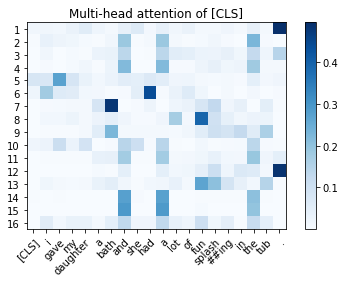

In [ ]:
weights = np.array(weights)[:,0:len(input_tokens)-1]

fig, ax = plt.subplots()
im = ax.imshow(weights,cmap=plt.cm.Blues)
# We want to show all ticks...
ax.set_xticks(np.arange(len(input_tokens)-1))
ax.set_yticks(np.arange(16))
# ... and label them with the respective list entries
ax.set_xticklabels(input_tokens)
ax.set_yticklabels([i for i in range(1,17)])
plt.colorbar(im)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Multi-head attention of [CLS]")
fig.tight_layout()
plt.show()

In this visualization, x-axis is the key which attention is being paid, y-axis is number of layer. 

Color intensity reflects the attention weight. 


### Advanced visualization tool

We can use [`bertviz`](https://github.com/jessevig/bertviz) tool to visualize attention in BERT. It extends the [Tensor2Tensor](https://github.com/tensorflow/tensor2tensor/tree/master/tensor2tensor/visualization) visualization tool by Llion Jones and the `Transformers` library from HuggingFace.


Install and import related libraries.

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1312 (delta 64), reused 63 (delta 28), pack-reused 1203
Receiving objects: 100% (1312/1312), 213.58 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (827/827), done.


In [ ]:
from bertviz import head_view

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

Interactive visualization.

You can check the weights of each head of each layer interactively.

This view visualizes attention as lines connecting the word being updated (left) (i.e, key) with the word being attended to (right) (i.e., query), following the design of the figures above. Color intensity reflects the attention weight; weights close to one show as very dark lines, while weights close to zero appear as faint lines or are not visible at all. The user may highlight a particular word to see the attention from that word only. 

In [ ]:
call_html()
# give attention weights and the list of tokens to head_view() function
head_view(attention_weights, input_tokens)

<IPython.core.display.Javascript object>

With `BertViz`, we also can visualize attention in all of the heads at once, using the `model view', and visualize how attention weights are computed from query and key vectors using the `neuron view`.

`BertViz` also supports the visualization of other transformer-based models (e.g., BERT, GPT-2, XLNet, RoBERTa, and XLM). 

If you are interested in exploring this visualization tool please visit [`BertViz` repository](https://github.com/jessevig/bertviz). 

### References:
* http://mccormickml.com/2019/07/22/BERT-fine-tuning/
* https://huggingface.co/transformers/index.html
* https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=_QXZhFb4LnV5
* https://github.com/google-research/bert
* https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1